In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN, HDBSCAN, OPTICS, Birch
import hdbscan

In [2]:
root_path = "/home/shuhangli/FMNP/sim_matrix/share_shuhang_02272025"

def get_np_data(eventid):
    similarity_data = np.load(f"{root_path}/feature_pairwise_similarity/{eventid}.npy")
    seg_data = np.load(f"{root_path}/seg_labels/{eventid}.npy")
    loss_data = np.load(f"{root_path}/losses/{eventid}.npy")
    return similarity_data, seg_data, loss_data



In [123]:
sim, seg, loss = get_np_data(1)
print(sim.shape)
print(seg.shape)
print(loss.shape)
#squeeze
sim = sim.squeeze()
seg = seg.squeeze()
epsilon = 1e-6
#distance_matrix = 1 - sim
#distance is actually sqrt(1 - sim)
distance_matrix = np.sqrt(1 - sim)
# zero vertex with the same shape of sim
zero_vertex = np.zeros(sim.shape)
#check fot nan
if np.isnan(distance_matrix).any():
    print("nan in distance matrix")
    #show the sim in that position
    nan_index = np.where(np.isnan(distance_matrix))
    print("nan index:", nan_index)
    print("sim value:", sim[nan_index])
    #set the nan to 0
    distance_matrix[nan_index] = 0
#convert distance type to double
distance_matrix = distance_matrix.astype(float)

seg_gt = (seg[:, None] == seg[None, :]).astype(float)

(1, 945, 945)
(1, 945)
()
nan in distance matrix
nan index: (array([  0,   1,   4,   9,  12,  16,  17,  20,  21,  22,  23,  25,  30,
        31,  32,  35,  37,  38,  40,  41,  43,  45,  49,  51,  52,  58,
        66,  67,  79,  80,  82,  84,  90, 100, 105, 108, 110, 112, 113,
       117, 120, 121, 123, 128, 130, 131, 136, 140, 143, 147, 150, 153,
       156, 157, 159, 160, 161, 166, 167, 168, 169, 170, 171, 178, 180,
       181, 185, 189, 191, 192, 193, 195, 198, 200, 203, 204, 205, 206,
       208, 209, 214, 216, 217, 218, 219, 220, 221, 225, 229, 233, 238,
       240, 241, 243, 244, 246, 251, 252, 257, 260, 266, 269, 270, 271,
       274, 275, 276, 277, 278, 280, 284, 285, 286, 289, 291, 295, 296,
       297, 299, 300, 303, 304, 307, 308, 314, 315, 319, 323, 329, 332,
       335, 337, 340, 342, 343, 344, 346, 347, 350, 351, 352, 353, 356,
       360, 363, 369, 372, 375, 379, 381, 382, 387, 389, 392, 394, 395,
       396, 401, 403, 406, 407, 411, 412, 417, 419, 420, 421, 427, 429,
   

/tmp/ipykernel_1824820/1258685139.py:11: RuntimeWarning: invalid value encountered in sqrt
  distance_matrix = np.sqrt(1 - sim)


In [71]:
def most_popular_in_group(df: pd.DataFrame, group_col: str, target_col: str) -> pd.DataFrame:
    """
    Generic function that, for each unique value of `group_col`,
    finds the most frequent (most popular) `target_col` value, its count,
    and the ratio of that count to the total rows in that group.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.
    group_col : str
        The column name to group by (e.g. 'cluster_trkid').
    target_col : str
        The column name whose most popular value you're looking for (e.g. 'cluster_predict').

    Returns
    -------
    pd.DataFrame
        A DataFrame with the following columns:
            - group_col (the group identifier),
            - 'most_popular_<target_col>' (the most frequent target value),
            - 'most_popular_count' (how many times that target value appears),
            - 'ratio' (the fraction of rows in this group that have that target value).
    """
    results = []

    for group_val in df[group_col].unique():
        # Filter rows where group_col == group_val
        sub_df = df[df[group_col] == group_val]
        
        # Count occurrences of target_col
        counts = sub_df[target_col].value_counts()

        # Find which target_col value is most frequent and how many times it appears
        most_popular = counts.idxmax()
        most_popular_count = counts.max()
        total_count = counts.sum()
        ratio = most_popular_count / total_count

        # Append results: (group_val, most_popular, most_popular_count, ratio)
        results.append((group_val, most_popular, most_popular_count, ratio))

    # Build the output DataFrame
    # Notice how we dynamically name the "most_popular_<target_col>" column
    results_df = pd.DataFrame(
        results,
        columns=[
            group_col,
            f"most_popular_{target_col}",
            "most_popular_count",
            "ratio"
        ]
    )
    return results_df



def all_values_ratio_in_group(df: pd.DataFrame, group_col: str, target_col: str) -> pd.DataFrame:
    """
    For each unique value of `group_col`, finds all possible values in `target_col`,
    their counts, the total rows in the group, and the ratio of each count to the total.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.
    group_col : str
        The column name to group by.
    target_col : str
        The column name to find all values for within each group.

    Returns
    -------
    pd.DataFrame
        A DataFrame with the following columns:
            - group_col (the group identifier),
            - target_col (the value within the target column),
            - '<target_col>_count' (the count of this value in the group),
            - '<target_col>_total' (the total rows in the group),
            - '<target_col>_ratio' (the fraction of rows in this group that have this value).
    """
    # Group by the group and target columns, then count occurrences
    grouped = df.groupby([group_col, target_col]).size().reset_index(name='count')
    
    # Calculate total rows per group and compute ratio
    grouped['total'] = grouped.groupby(group_col)['count'].transform('sum')
    grouped['ratio'] = grouped['count'] / grouped['total']
    
    # Rename columns to include the target_col name
    grouped = grouped.rename(columns={
        'count': f'{target_col}_count',
        'total': f'{group_col}_total',
        'ratio': f'{target_col}_ratio'
    })
    
    return grouped

def make_unique_trkid_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a DataFrame with one row per unique cluster_trkid,
    including columns: cluster_trkid, px, py, pz, vtx_x, vtx_y, vtx_z.

    Since px, py, pz, vtx_x, vtx_y, vtx_z are assumed identical for the same
    cluster_trkid, we can simply take the 'first' entry from each group.
    """
    grouped_df = (
        df.groupby('true_label', as_index=False)
          [['px','py','pz','vtx_x','vtx_y','vtx_z']]
          .first()
    )
    return grouped_df


In [61]:
#clustering based on voting
import numpy as np

def vote_clustering(sim_matrix, sim_thresh, vote_thresh):
    """
    Custom clustering algorithm that returns cluster labels (-1 for unclustered).
    
    Args:
        sim_matrix (np.ndarray): 2D similarity matrix (shape [n_samples, n_samples]).
        sim_thresh (float): Similarity threshold for cluster acceptance.
        vote_thresh (float): Fraction of cluster members required to accept a new point.
    
    Returns:
        tuple: (clusters, labels) where:
            - clusters: List of clusters (each as a list of indices).
            - labels: Array where labels[i] = cluster ID or -1 (unclustered).
    """
    n = sim_matrix.shape[0]
    clustered = np.zeros(n, dtype=bool)
    clusters = []
    labels = np.full(n, -1, dtype=int)  # Initialize all labels to -1
    
    for p in range(n):
        if clustered[p]:
            continue
        
        added = False
        
        # Step 1: Check existing clusters
        for cluster_id, cluster in enumerate(clusters):
            similarities = sim_matrix[p, cluster]
            vote_ratio = np.sum(similarities >= sim_thresh) / len(cluster)
            
            if vote_ratio >= vote_thresh:
                cluster.append(p)
                clustered[p] = True
                labels[p] = cluster_id  # Assign cluster ID
                added = True
                break
        
        # Step 2: If not added, check unclustered points (excluding self)
        if not added:
            unclustered = np.where(~clustered)[0]
            others = unclustered[unclustered != p]  # Exclude self
            candidates = others[sim_matrix[p, others] >= sim_thresh]
            
            if len(candidates) > 0:
                new_cluster = [p] + list(candidates)
                clusters.append(new_cluster)
                clustered[new_cluster] = True
                cluster_id = len(clusters) - 1
                labels[new_cluster] = cluster_id  # Assign new cluster ID
            else:
                # Leave p unclustered (label remains -1)
                pass
    
    return clusters, labels

In [ ]:
#distance_matrix[distance_matrix > 0.95] = 10.0  # Adjust threshold based on sparsity

clusterer = hdbscan.HDBSCAN(
    metric="precomputed",       # Use precomputed distance matrix
    #min_cluster_size=5,         # Adjust based on expected smallest cluster
    #min_samples=None,             # Controls sensitivity to noise
    cluster_selection_epsilon=0.0  # Helps separate close clusters
)
clusterer.fit(distance_matrix)

labels = clusterer.labels_
print(labels)
#print(seg)

[-1 -1 -1 -1 -1 -1 -1  2  2  2  2  2  2  2  2  2  2 -1 -1 -1  7  7  7  7
 -1 -1 -1  7 -1  8 -1  8  8  8  8  8  8  8 -1 -1 -1 -1 -1  9 -1  9  9  9
  9 -1  9 -1 -1 -1 -1  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3 -1
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3 -1  1  1  1  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3 -1 -1 -1 -1 -1  3  3  3  3  3  3  3
  3  3  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  5  5  5  5 -1  5
  5  5  5  5  5 -1 -1  7  7  7  7  7  7 -1  9  9  9 -1  9  9  9  9  9 -1
  9  9 -1  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  1  1  1  1  1  1  1 -1 -1 -1 -1 -1  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3 -1 -1 -1  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3 -1  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [62]:
cluster, labels = vote_clustering(sim, 0.5, 0.5)

print(labels)

[ 0  0  0  0  0  1  1  1  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  3
  3  3  3  4  3  3  4  4  4  4  4  5  5  5  5  5  6  6  6  6  7  7  7  7
  7  7  8  8  4  4  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10
 10  9  9  9  9  9  9 11 11 11 11 11 11 11 11 12 12 13 13 14 14 14  9 14
 14 14 10 14 14 14 14 10 14 14 15 15 15 15 16 16 16 16 17 18 17 17 17 17
 17 18 17 19 19 19 19 19 19 19 20 20 20 20 20 21 21 22  0 22 22 22 23 23
 23 23 23 23 24 24 25  4  4  4 25  4  4  6  6  6  6  6  7  7  7  7  7  8
  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9 26 26 26 26 26  9  9  9 12
 14 14 11 14  9  9  9 11 11 10 11 11 11 11 11  9 11  9 11  9  9  9  9 11
  9  9  9  9  9  9  9  9 10 10 10 10  9  9  9 10 11 11 11 11  9  9 26 11
 26 12 12 13 13 13 13 13 27 27 27 28 28 29 29 29 29 29 29 29 14 29 29 29
 29 29 29 14 10 10 30 30 30 31 31 31 31 31 31 31 31 29 31 31 31 31 31 31
 31 31 32 32 32 17 18 17 17 18 17 18 17 18 17 33 33 33 33 33 33 33 33 33
 33 19 19 19 19 19 19 19 19 19 34 20 20 21 21 21 21

[   29    29 -6170 -6170 -6170 -6170    29 -6170    29 -6170 -6170 -6170
 -6170    29 -6170    29    29    29    11    11    11    11    11    11
    11    11 -8818 -8818 -8818 -8818 -8820 -8820 -8820 -8820 -8820 -8820
 -8820 -8820 -6699    13 -6699    13    13    13 -6699    13    13 -6699
    13 -6699 -6699    13 -8818 -8818 -6342 -6342 -6342 -6342 -6342 -6342
 -6342 -6342 -6342 -6342 -6342 -6342 -6342 -6342 -6342 -6342 -6342    17
    17    17    17    17    17    17 -6581 -6581 -6581 -6581 -6581 -6581
 -6581 -6581 -6581     9     9     9     9    17    17    17    17    15
    15    17    17    17    15    17    15    17    17    17    15    17
    15    15 -3506 -2631 -3506 -2631 -3506 -2631 -2631 -3506 -2631 -3506
 -3506 -2631 -2631 -8819 -8819 -8819 -8819 -8819 -8819 -8819    14    14
    14    14    14    14    14    29    29    29    29    29    11    11
    11    11    11    11    11    11 -8818 -8818 -8818 -8818 -8818 -8818
 -8818 -6699    13 -6699    13 -6699    13    13 -6

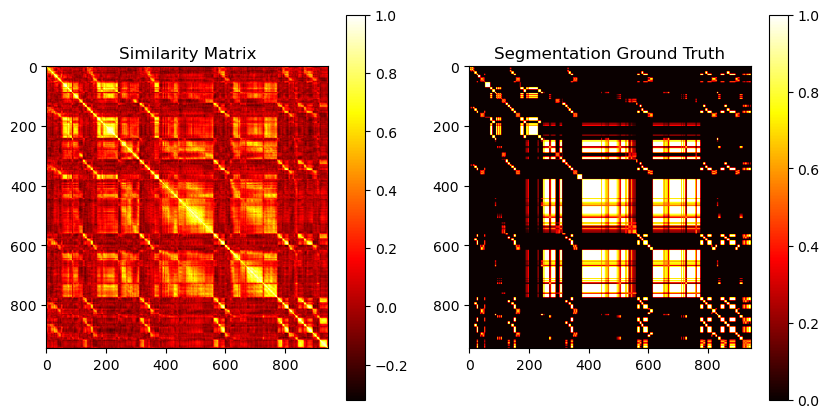

In [56]:
#visualize sim and seg_gt
print(seg)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sim, cmap='hot')
plt.title("Similarity Matrix")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(seg_gt, cmap='hot')
plt.title("Segmentation Ground Truth")
plt.colorbar()

In [30]:
# sim is prediction seg_gt is ground truth
threshold = 0.3
pred = (sim > threshold).astype(float)
# calculate accuracy, fpr, tpr, precision, recall
def calculate_metrics(pred, gt):
    tp = np.sum((pred == 1) & (gt == 1))
    tn = np.sum((pred == 0) & (gt == 0))
    fp = np.sum((pred == 1) & (gt == 0))
    fn = np.sum((pred == 0) & (gt == 1))

    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    fpr = fp / (fp + tn) if fp + tn > 0 else 0
    tpr = tp / (tp + fn) if tp + fn > 0 else 0
    
    return accuracy, fpr, tpr, precision, recall

def calculate_loss(sim, seg_gt):
    #mse of the lower triangle of sim and seg_gt
    loss = np.mean((sim[np.tril_indices(sim.shape[0], -1)] - seg_gt[np.tril_indices(seg_gt.shape[0], -1)]) ** 2)
    #loss = np.mean((sim - seg_gt) ** 2)
    return loss

accuracy, fpr, tpr, precision, recall = calculate_metrics(pred, seg_gt)
print(f"Accuracy: {accuracy}")
print(f"False Positive Rate: {fpr}")
print(f"True Positive Rate: {tpr}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
loss = calculate_loss(pred, seg_gt)
print(f"Loss: {loss}")

Accuracy: 0.8533725259651186
False Positive Rate: 0.10194721294424816
True Positive Rate: 0.6264964303458038
Precision: 0.5475597061535259
Recall: 0.6264964303458038
Loss: 0.14678279974890143


In [135]:
# loop over 1000 events
accuracy_list = []
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
loss_list = []
df_sim_hdbscan_list = []
df_sim_vote_list = []

for i in range(1000):
    sim, seg, loss = get_np_data(i)
    sim = sim.squeeze()
    seg = seg.squeeze()
    seg_gt = (seg[:, None] == seg[None, :]).astype(float)
    pred = (sim > threshold).astype(float)
    accuracy, fpr, tpr, precision, recall = calculate_metrics(pred, seg_gt)
    loss = calculate_loss(pred, seg_gt)
    accuracy_list.append(accuracy)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    precision_list.append(precision)
    recall_list.append(recall)
    loss_list.append(loss)
    #apply clustering
    sim = sim.astype(float)
    #distance_matrix = 1 - sim
    #set sim greater than 1 to 1
    sim[sim > 1] = 1
    #set sim less than 0 to 0
    sim[sim < 0] = 0
    distance_matrix = np.sqrt(2*(1 - sim))
    #distance_matrix = 1 - sim
    #check fot nan
    if np.isnan(distance_matrix).any():
        nan_index = np.where(np.isnan(distance_matrix))
        #set the nan to 0
        distance_matrix[nan_index] = 0
    clusterer = hdbscan.HDBSCAN(
        metric="precomputed",       # Use precomputed distance matrix
        #min_cluster_size=10,         # Adjust based on expected smallest cluster
        #min_samples=3,              # Controls sensitivity to noise
        #cluster_selection_epsilon=0.2  # Helps separate close clusters
    )
    clusterer.fit(distance_matrix)
    labels = clusterer.labels_
    target = seg
    #check the length of labels and target
    if len(labels) != len(target):
        print(f"Length of labels and target do not match for event {i}")
        print(f"Length of labels: {len(labels)}, Length of target: {len(target)}")
        continue
    current_df = pd.DataFrame({
    'event_idx': i,
    'cluster_idx': 0,
    'pred_label': labels,
    'true_label': target,
    #pad the flollwing
    'px': 1,
    'py': 0,
    'pz': 0,
    'vtx_x': 0,
    'vtx_y': 0,
    'vtx_z': 0,
    'q': 1,
    'e': 1
    })
    df_sim_hdbscan_list.append(current_df)
    #apply vote clustering
    cluster, labels = vote_clustering(sim, 0.5, 0.3)
    target = seg
    current_df = pd.DataFrame({
    'event_idx': i,
    'cluster_idx': 0,
    'pred_label': labels,
    'true_label': target,
    #pad the flollwing
    'px': 1,
    'py': 0,
    'pz': 0,
    'vtx_x': 0,
    'vtx_y': 0,
    'vtx_z': 0,
    'q': 1,
    'e': 1
    })
    df_sim_vote_list.append(current_df)
    print(f"Event {i}")


#average'
accuracy = np.mean(accuracy_list)
fpr = np.mean(fpr_list)
tpr = np.mean(tpr_list)
precision = np.mean(precision_list)
recall = np.mean(recall_list)
loss = np.mean(loss_list)
print(f"Accuracy: {accuracy}")
print(f"False Positive Rate: {fpr}")
print(f"True Positive Rate: {tpr}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Loss: {loss}")

Event 0
Event 1
Event 2
Event 3
Event 4
Event 5
Event 6
Event 7
Event 8
Event 9
Event 10
Event 11
Event 12
Event 13
Event 14
Event 15
Event 16
Event 17
Event 18
Event 19
Event 20
Event 21
Event 22
Event 23
Event 24
Event 25
Event 26
Event 27
Event 28
Event 29
Event 30
Event 31
Event 32
Event 33
Event 34
Event 35
Event 36
Event 37
Event 38
Event 39
Event 40
Event 41
Event 42
Event 43
Event 44
Event 45
Event 46
Event 47
Event 48
Event 49
Event 50
Event 51
Event 52
Event 53
Event 54
Event 55
Event 56
Event 57
Event 58
Event 59
Event 60
Event 61
Event 62
Event 63
Event 64
Event 65
Event 66
Event 67
Event 68
Event 69
Event 70
Event 71
Event 72
Event 73
Event 74
Event 75
Event 76
Event 77
Event 78
Event 79
Event 80
Event 81
Event 82
Event 83
Event 84
Event 85
Event 86
Event 87
Event 88
Event 89
Event 90
Event 91
Event 92
Event 93
Event 94
Event 95
Event 96
Event 97
Event 98
Event 99
Event 100
Event 101
Event 102
Event 103
Event 104
Event 105
Event 106
Event 107
Event 108
Event 109
Event 110


/tmp/ipykernel_1824820/1776655396.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('size_bin').agg({


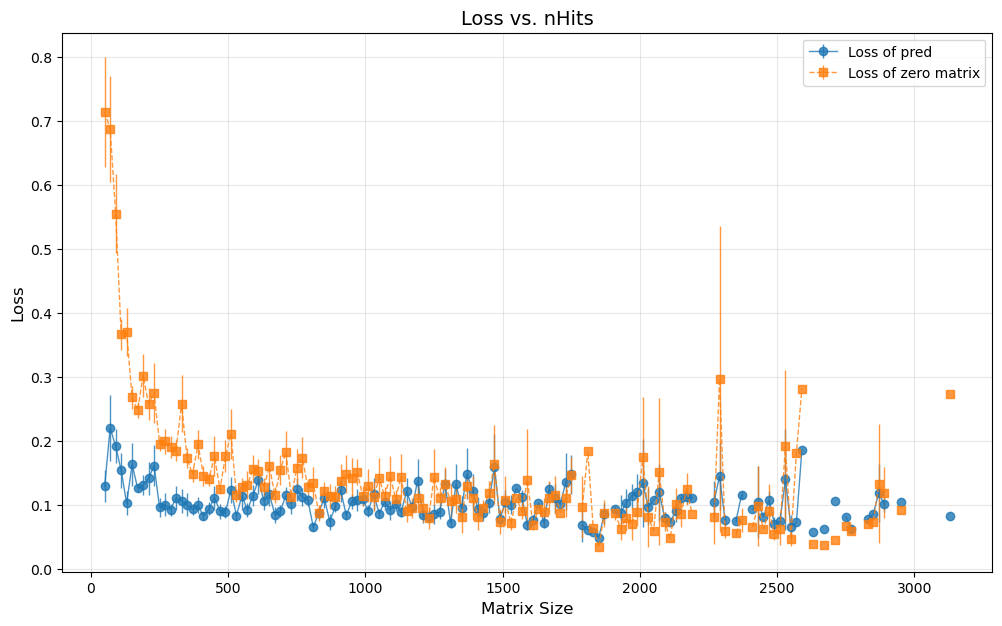

In [147]:
# Loop over 1000 events
accuracy_list = []
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
loss_gt_list = []  # Original loss (pred vs seg_gt)
loss_zero_list = []  # New loss (sim vs zero matrix)
size_list = []  # Track matrix size

for i in range(1000):
    sim, seg, _ = get_np_data(i)  # Assuming loss is not precomputed
    sim = sim.squeeze()
    seg = seg.squeeze()
    n = sim.shape[0]
    size_list.append(n)
    
    # Ground truth matrix
    seg_gt = (seg[:, None] == seg[None, :]).astype(float)
    pred = (sim > threshold).astype(float)  # Thresholded predictions
    
    # Calculate original loss (pred vs seg_gt)
    loss_gt = calculate_loss(pred, seg_gt)
    loss_gt_list.append(loss_gt)
    
    # Calculate loss against zero matrix (sim vs zeros)
    zero_matrix = np.zeros_like(sim)
    loss_zero = calculate_loss(zero_matrix, seg_gt)  # Directly use raw `sim`
    loss_zero_list.append(loss_zero)

df = pd.DataFrame({
    'size': size_list,
    'loss_gt': loss_gt_list,
    'loss_zero': loss_zero_list
})

bin_width = 20
max_size = df['size'].max()
bins = list(range(0, int(max_size) + bin_width, bin_width))

df['size_bin'] = pd.cut(df['size'], bins=bins, include_lowest=True)


grouped = df.groupby('size_bin').agg({
    'loss_gt': ['mean', 'std', 'count'],
    'loss_zero': ['mean', 'std', 'count']
}).reset_index()


grouped['loss_gt_sem'] = grouped[('loss_gt', 'std')] / np.sqrt(grouped[('loss_gt', 'count')])
grouped['loss_zero_sem'] = grouped[('loss_zero', 'std')] / np.sqrt(grouped[('loss_zero', 'count')])
grouped['bin_mid'] = grouped['size_bin'].apply(lambda x: x.mid)

grouped.columns = ['size_bin', 
                   'loss_gt_mean', 'loss_gt_std', 'loss_gt_count',
                   'loss_zero_mean', 'loss_zero_std', 'loss_zero_count',
                   'loss_gt_sem', 'loss_zero_sem', 'bin_mid']

# --- Plotting ---
plt.figure(figsize=(12, 7))
plt.errorbar(grouped['bin_mid'], grouped['loss_gt_mean'], 
             yerr=grouped['loss_gt_sem'], fmt='o-',  
             label='Loss of pred', alpha=0.8, linewidth=1)
plt.errorbar(grouped['bin_mid'], grouped['loss_zero_mean'], 
             yerr=grouped['loss_zero_sem'], fmt='s--', 
             label='Loss of zero matrix', alpha=0.8, linewidth=1)

plt.xlabel(f'Matrix Size', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss vs. nHits', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



In [136]:
#df = df_sim_hdbscan_list[1]
df = df_sim_vote_list[1]


popular_predict_df_eff = most_popular_in_group(
    df,
    group_col='true_label',
    target_col='pred_label'
)

all_predict_df_eff = all_values_ratio_in_group(
    df,
    group_col='true_label',
    target_col='pred_label'
)

popular_predict_df_pure = most_popular_in_group(
            df,
            group_col='pred_label',
            target_col='true_label'
        )

all_predict_df = all_predict_df_eff.merge(
    popular_predict_df_pure,
    how='left',
    left_on='pred_label',
    right_on='pred_label',
    suffixes=('_eff', '_pure')
)

print(all_predict_df)

    true_label  pred_label  pred_label_count  true_label_total  \
0        -8820           2                 8                 8   
1        -8819          12                20                20   
2        -8818           2                40               119   
3        -8818           5                 7               119   
4        -8818          12                18               119   
..         ...         ...               ...               ...   
86          17           6                50                67   
87          17           7                17                67   
88          29           0                10                17   
89          29           1                 6                17   
90          29          14                 1                17   

    pred_label_ratio  most_popular_true_label  most_popular_count     ratio  
0           1.000000                    -8818                  40  0.714286  
1           1.000000                    -8819      

In [137]:
selected_event_idx = 3

# Initialize new lists for similarity-based methods
df_sim_vote_processed_list = []
df_sim_hdbscan_processed_list = []
df_sim_vote_all_list = []
df_sim_hdbscan_all_list = []

# Create list of method dataframe lists
method_df = [df_sim_vote_list, df_sim_hdbscan_list]

for df_list in method_df:
    if df_list is df_sim_vote_list:
        print('[INFO] Processing Similarity Vote clustering results...')
    else:
        print('[INFO] Processing Similarity HDBSCAN clustering results...')
        
    for df in df_list:
        # Process effective predictions
        popular_predict_df_eff = most_popular_in_group(
            df,
            group_col='true_label',
            target_col='pred_label'
        )
        
        # Process pure predictions
        popular_predict_df_pure = most_popular_in_group(
            df,
            group_col='pred_label',
            target_col='true_label'
        )
        
        # Merge effective and pure predictions
        popular_predict_df = popular_predict_df_eff.merge(
            popular_predict_df_pure,
            how='left',
            left_on='most_popular_pred_label',
            right_on='pred_label',
            suffixes=('_eff', '_pure')
        )
        
        # Process all value ratios
        all_predict_df_eff = all_values_ratio_in_group(
            df,
            group_col='true_label',
            target_col='pred_label'
        )
        
        # Merge with pure predictions
        all_predict_df = all_predict_df_eff.merge(
            popular_predict_df_pure,
            how='left',
            left_on='pred_label',
            right_on='pred_label',
            suffixes=('_eff', '_pure')
        )
        
        # Merge with unique track IDs
        df_grouped = make_unique_trkid_df(df)
        
        popular_predict_df = popular_predict_df.merge(
            df_grouped,
            how='left',
            left_on='true_label',
            right_on='true_label',
        )
        
        all_predict_df = all_predict_df.merge(
            df_grouped,
            how='left',
            left_on='true_label',
            right_on='true_label',
        )
        
        # Append to appropriate lists
        if df_list is df_sim_vote_list:
            df_sim_vote_processed_list.append(popular_predict_df)
            df_sim_vote_all_list.append(all_predict_df)
        else:
            df_sim_hdbscan_processed_list.append(popular_predict_df)
            df_sim_hdbscan_all_list.append(all_predict_df)

# Print sample output
print(df_sim_vote_all_list[2])  # Assuming there are at least 3 elements

[INFO] Processing Similarity Vote clustering results...


[INFO] Processing Similarity HDBSCAN clustering results...
    true_label  pred_label  pred_label_count  true_label_total  \
0        -3764           1                 1                59   
1        -3764           2                 5                59   
2        -3764          21                52                59   
3        -3764          22                 1                59   
4        -3762          -1                 1                52   
5        -3762           2                29                52   
6        -3762           3                19                52   
7        -3762          22                 3                52   
8        -3691           0                 7               118   
9        -3691           1                75               118   
10       -3691           4                11               118   
11       -3691           5                 3               118   
12       -3691           6                 2               118   
13       -3691   

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



def calculate_efficiency_new(df_list, eff_threshold, pure_threshold, n_bins=1):
    """Process a list of DataFrames to calculate efficiency and average ratio_pure vs pT."""
    # Concatenate all DataFrames for this clustering method
    track_df_list = []
    processed_df_list = []

    for df_temp in df_list:

        #print(df_temp.head())
        df = df_temp.copy()
        # Calculate transverse momentum
        df['pT'] = np.sqrt(df['px']**2 + df['py']**2)
    
        # we want reco tracks that pass purity cut(fit able), that match back to the true track
        df['pass_cut'] = (df['pred_label_count'] > eff_threshold) & \
                              (df['ratio'] > pure_threshold) &\
                              (df['most_popular_true_label'] == df['true_label'])
        
    
        # for each truth track, how many of them pass the cut
        df['pass_cut_count'] = df.groupby('true_label')['pass_cut'].transform('sum')
        track_df = df.drop_duplicates(subset='pred_label', inplace=False)
        track_df['enough_hits'] = track_df['pred_label_count'] > eff_threshold
        track_df_list.append(track_df)
        df = df.drop_duplicates(subset='true_label', inplace=False)
        processed_df_list.append(df)

        
    combined_df = pd.concat(processed_df_list, ignore_index=True)
    combined_track_df = pd.concat(track_df_list, ignore_index=True)

    bins = np.percentile(combined_df['pT'], np.linspace(0, 100, n_bins+1))
    bins = np.unique(bins)  # Remove duplicate edges
    #print(bins)
    
    # Bin the data
    #hack for pT bins
    combined_df['pT_bin'] = 0
    combined_track_df['pT_bin'] = 0
    #combined_df['pT_bin'] = pd.cut(combined_df['pT'], bins=bins, include_lowest=True)
    #combined_track_df['pT_bin'] = pd.cut(combined_track_df['pT'], bins=bins, include_lowest=True)

    #print(combined_df.head())

    # efficiency is the ratio of pass cut count greater than 1
    # n seed per track is the mean of non zero pass cut count
    # purity is the ratio of pass cut count greater than 1 over enough hits count
    efficiency_data = []
    for bin_name, bin_group in combined_df.groupby('pT_bin'):
        #print(bin_name)
        # Efficiency: Fraction of tracks with ≥1 valid reconstructed track
        valid_tracks = bin_group[bin_group['true_label_total'] > eff_threshold]
        
        # Efficiency calculation with filtered denominator
        total_tracks = len(valid_tracks)
        efficient_tracks = (valid_tracks['pass_cut_count'] >= 1).sum()
        efficiency = efficient_tracks / total_tracks if total_tracks > 0 else 0
        
        # Average seeds per track (non-zero cases only)
        non_zero_seeds = valid_tracks[valid_tracks['pass_cut_count'] > 0]['pass_cut_count']
        n_seed_per_track = non_zero_seeds.mean() if not non_zero_seeds.empty else 0
        
        
        efficiency_data.append({
            #'pT_center': bin_name.mid,
            'pT_center': 1,
            'efficiency': efficiency,
            'n_seed_per_track': n_seed_per_track,
        })
    
    purity_data = []
    for bin_name, bin_group in combined_track_df.groupby('pT_bin'):
        # Purity: average of column 'ratio' where enough_hits is True
        enough_hits = bin_group['enough_hits']
        purity = bin_group[enough_hits]['ratio'].mean() if enough_hits.any() else 0

        purity_data.append({
            #'pT_center': bin_name.mid,
            'pT_center': 1,
            'purity': purity,
        })

    return pd.DataFrame(efficiency_data), pd.DataFrame(purity_data)

# Set your thresholds here
EFF_THRESHOLD = 20
PURE_THRESHOLD = 0.9

# Calculate efficiencies for both methods

hdbscan_efficiency_new, hdbscan_purity = calculate_efficiency_new(df_sim_hdbscan_all_list, EFF_THRESHOLD, PURE_THRESHOLD)
vote_efficiency_new, vote_purity = calculate_efficiency_new(df_sim_vote_all_list, EFF_THRESHOLD, PURE_THRESHOLD)

print(hdbscan_efficiency_new)
print(hdbscan_purity)

print(vote_efficiency_new)
print(vote_purity)





/tmp/ipykernel_1824820/3121802916.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['enough_hits'] = track_df['pred_label_count'] > eff_threshold
/tmp/ipykernel_1824820/3121802916.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['enough_hits'] = track_df['pred_label_count'] > eff_threshold
/tmp/ipykernel_1824820/3121802916.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

   pT_center  efficiency  n_seed_per_track
0          1    0.477813          1.165852
   pT_center   purity
0          1  0.92459
   pT_center  efficiency  n_seed_per_track
0          1    0.382943          1.150789
   pT_center    purity
0          1  0.890755
